In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
path.ls()

(#4) [Path('C:/Users/Administrator/.fastai/data/imagenette2-160/.DS_Store'),Path('C:/Users/Administrator/.fastai/data/imagenette2-160/noisy_imagenette.csv'),Path('C:/Users/Administrator/.fastai/data/imagenette2-160/train'),Path('C:/Users/Administrator/.fastai/data/imagenette2-160/val')]

## Loading the data with a factory method

In [5]:
doc(Normalize.from_stats)

In [6]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [8]:
doc(ImageDataLoaders.from_folder)

In [4]:
dls=ImageDataLoaders.from_folder(path,valid='val',item_tfms=RandomResizedCrop(128, min_scale=0.35),batch_tfms=Normalize.from_stats(*imagenet_stats))

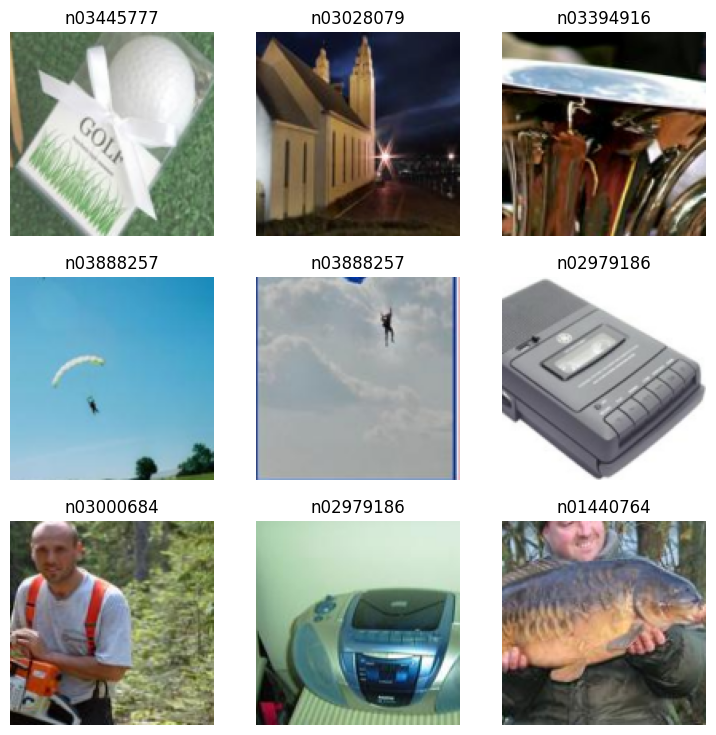

In [5]:
dls.show_batch()

## Loading the data with the data block API

### 空的datablock

In [6]:
dblock=DataBlock()
dsets=dblock.datasets(get_image_files(path)) #给出所有文件
#输出2给是因为,dsets默认数据集由(input,target构成)
dsets.train[0]

(Path('C:/Users/Administrator/.fastai/data/imagenette2-160/val/n03445777/n03445777_3722.JPEG'),
 Path('C:/Users/Administrator/.fastai/data/imagenette2-160/val/n03445777/n03445777_3722.JPEG'))

### 过滤，只保留图片

In [7]:
#结果和上面一样，只是这里是让dblock过滤从path中的数据
dblock=DataBlock(get_items = get_image_files)
dsets=dblock.datasets(path) #给出一个根目录
dsets.train[0]

(Path('C:/Users/Administrator/.fastai/data/imagenette2-160/train/n01440764/n01440764_21955.JPEG'),
 Path('C:/Users/Administrator/.fastai/data/imagenette2-160/train/n01440764/n01440764_21955.JPEG'))

### 过滤，获得target

In [12]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
def label_func(f):
    return lbl_dict[parent_label(f)]
# label_func=Pipeline([parent_label,lbl_dict.__getitem__])
dblock=DataBlock(get_items = get_image_files,
                 get_y=label_func)
dsets=dblock.datasets(path)
dsets.train[0]


(Path('C:/Users/Administrator/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00041247.JPEG'),
 'French horn')

### 加上 input,target的类型

In [13]:
dblock=DataBlock(get_items = get_image_files,
                 get_y=label_func,
                blocks=(ImageBlock,CategoryBlock))
dsets=dblock.datasets(path)
print(dsets.train[0])
print(dsets.vocab)


(PILImage mode=RGB size=235x160, TensorCategory(4))
['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']


### 划分数据集

In [91]:
doc(GrandparentSplitter)

In [14]:
# imagenette2-160/train/n03425413/n03425413_20527.JPEG
dblock=DataBlock(get_items = get_image_files,
                 get_y=label_func,
                 blocks=(ImageBlock,CategoryBlock),
                 splitter=GrandparentSplitter(valid_name='val'))
dsets=dblock.datasets(path)
len(dsets.train),len(dsets.valid)

(9469, 3925)

### 数据尺寸一直，数据处理

In [94]:
doc(RandomResizedCrop)

In [17]:
dblock=DataBlock(get_items = get_image_files,
                 get_y=label_func,
                 blocks=(ImageBlock,CategoryBlock),
                 splitter=GrandparentSplitter(valid_name='val'),
                 item_tfms=RandomResizedCrop((128,128),min_scale=0.35),
                 batch_tfms=Normalize.from_stats(*imagenet_stats))
dsets=dblock.datasets(path)
dsets.train[10],dsets.train[22]

((PILImage mode=RGB size=213x160, TensorCategory(9)),
 (PILImage mode=RGB size=213x160, TensorCategory(9)))

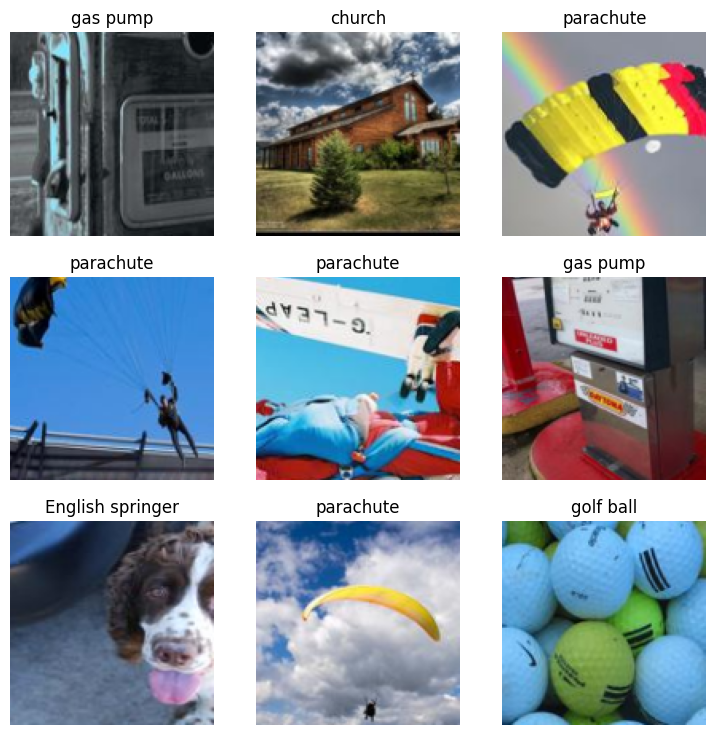

In [18]:
dls = dblock.dataloaders(path)
dls.show_batch()

## Loading the data with the mid-level API

In [19]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
fnames=get_image_files(path)

In [20]:
doc(Categorize)

In [21]:
#transform,对数据的一次更改就是一个transform
# Catagorize==Tokenizer
tfm=Pipeline([parent_label,lbl_dict.__getitem__,Categorize(vocab=lbl_dict.values())])
tfm(fnames[0])

TensorCategory(9)

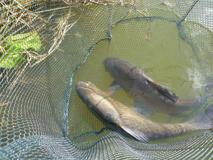

In [22]:
PILImage.create(fnames[0])

In [23]:
doc(Datasets)

In [24]:
splits = GrandparentSplitter(valid_name='val')(fnames)

x_tfms=[PILImage.create]
y_tfms=[parent_label,lbl_dict.__getitem__,Categorize()]
# 输入是fnames中的元素， 输出有2给元素，分别是fnames中的元素经过
# x_tfms，y_tfms转换的结果
dsets=Datasets(fnames,[x_tfms,y_tfms],splits=splits)
# dsets=Datasets(fnames,[x_tfms,y_tfms,y_tfms],splits=splits)

In [60]:
len(dsets.train),len(dsets.valid)
dsets.train[0]

(PILImage mode=RGB size=213x160, TensorCategory(9))

<AxesSubplot: title={'center': 'tench'}>

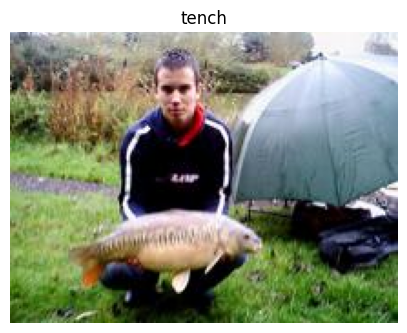

In [28]:
dsets.show(dsets[20])

In [29]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)] #+aug_transforms()

dls=dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

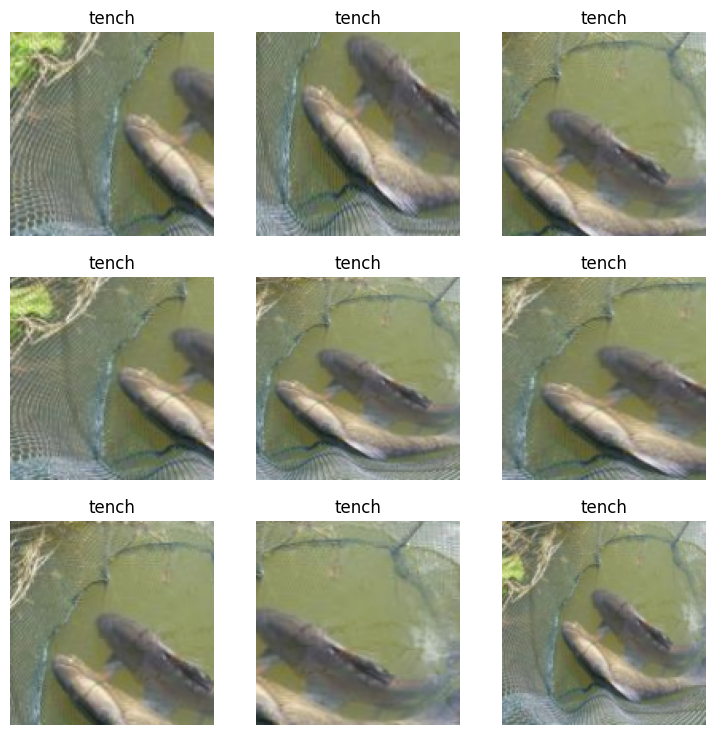

In [30]:
dls.train.show_batch(unique=True)

## 训练学习

In [31]:
learn = vision_learner(dls, resnet34, metrics=accuracy, pretrained=False)

D:\python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SuggestedLRs(valley=0.0008317637839354575)

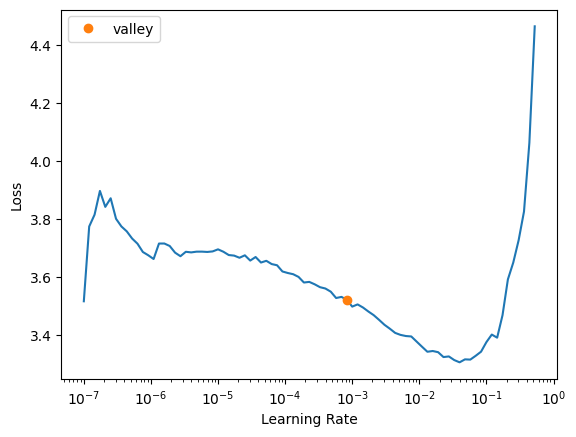

In [32]:
learn.lr_find()

In [36]:
doc(learn.fit_one_cycle)

In [38]:
learn.fit_one_cycle(5,10**(2/10)*1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.465642,1.989451,0.318217,01:59
1,1.922463,1.997036,0.343949,00:54
2,1.785570,2.927135,0.457070,00:54
3,1.455456,1.257578,0.588280,00:55
4,1.249131,1.075520,0.651210,00:54


In [45]:
#自定义的learner
learn=Learner(dls,xresnet34(n_out=10),metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.643125,1.692093,0.451210,01:00
1,1.202760,1.230623,0.594904,00:58
2,0.974309,1.144215,0.632611,00:58
3,0.810154,0.766910,0.752611,00:58
4,0.691257,0.721990,0.770701,00:58


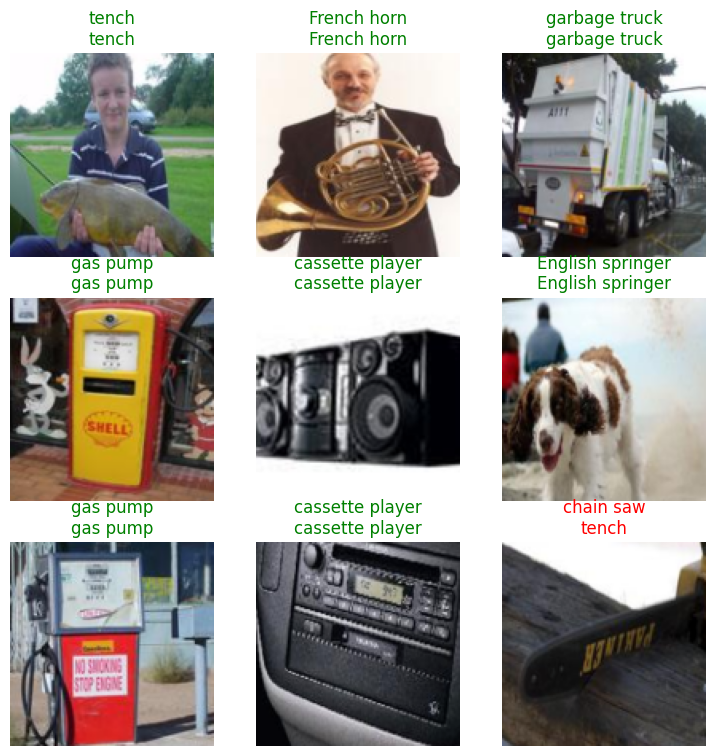

In [46]:
learn.show_results()

### predict的返回

In [49]:
predict_label,predict_index,all_probs=learn.predict(PILImage.create(fnames[1]))
print(predict_label,all_probs[predict_index])

tench tensor(0.9364)


In [86]:
doc(learn.get_preds)

In [89]:
#valid数据集上的返回
preds=learn.get_preds(with_loss=True,with_decoded=True)

In [92]:
print('preds_size=',len(preds))
print('preds logits=',preds[0].size())
print('preds label',preds[1])
print('preds decode',preds[2]) 
print('preds loss',preds[3])

preds_size= 4
preds logits= torch.Size([3925, 10])
preds label tensor([9, 9, 9,  ..., 8, 8, 8])
preds decode tensor([9, 9, 9,  ..., 8, 8, 1])
preds loss TensorBase([1.8950e-01, 3.2592e-02, 5.2665e-04,  ..., 1.7338e-01,
            6.2696e-02, 5.6747e+00])


### 自定义loss func

$$Loss(P,y)=-[(1-\epsilon)log(P_y) + \frac{\epsilon}{C}\sum_1^Clog(P_i)]$$

In [ ]:
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [95]:
learn=Learner(dls,xresnet34(n_out=10),loss_func=LabelSmoothingCrossEntropy(),metrics=accuracy)

In [96]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.724715,1.630629,0.524586,00:58
1,1.422375,1.422212,0.635669,00:58
2,1.254109,1.211179,0.711847,00:59
3,1.104707,1.105303,0.755669,01:00
4,1.024209,1.069168,0.769427,00:58
